In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pywt
import torch 
import scipy
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from hurst import compute_Hc, random_walk

In [2]:
temp_data = pd.read_csv('../Data/train_data.csv')
# Convert the 'date' column to datetime
temp_data['date'] = pd.to_datetime(temp_data['date'])
temp_data

,date,mean,max,min
0,1933-01-01,13.67,18.89,2.78
1,1933-01-02,13.89,19.61,1.89
2,1933-01-03,10.83,16.28,0.78
3,1933-01-04,14.94,21.28,1.28
4,1933-01-05,18.11,23.50,6.89
...,...,...,...,...
33281,2024-03-27,12.67,21.28,5.61
33282,2024-03-28,12.33,20.11,4.22
33283,2024-03-29,12.11,16.78,5.50
33284,2024-03-30,9.17,14.61,7.50


We skip the data analysis that is done in Main.ipynb

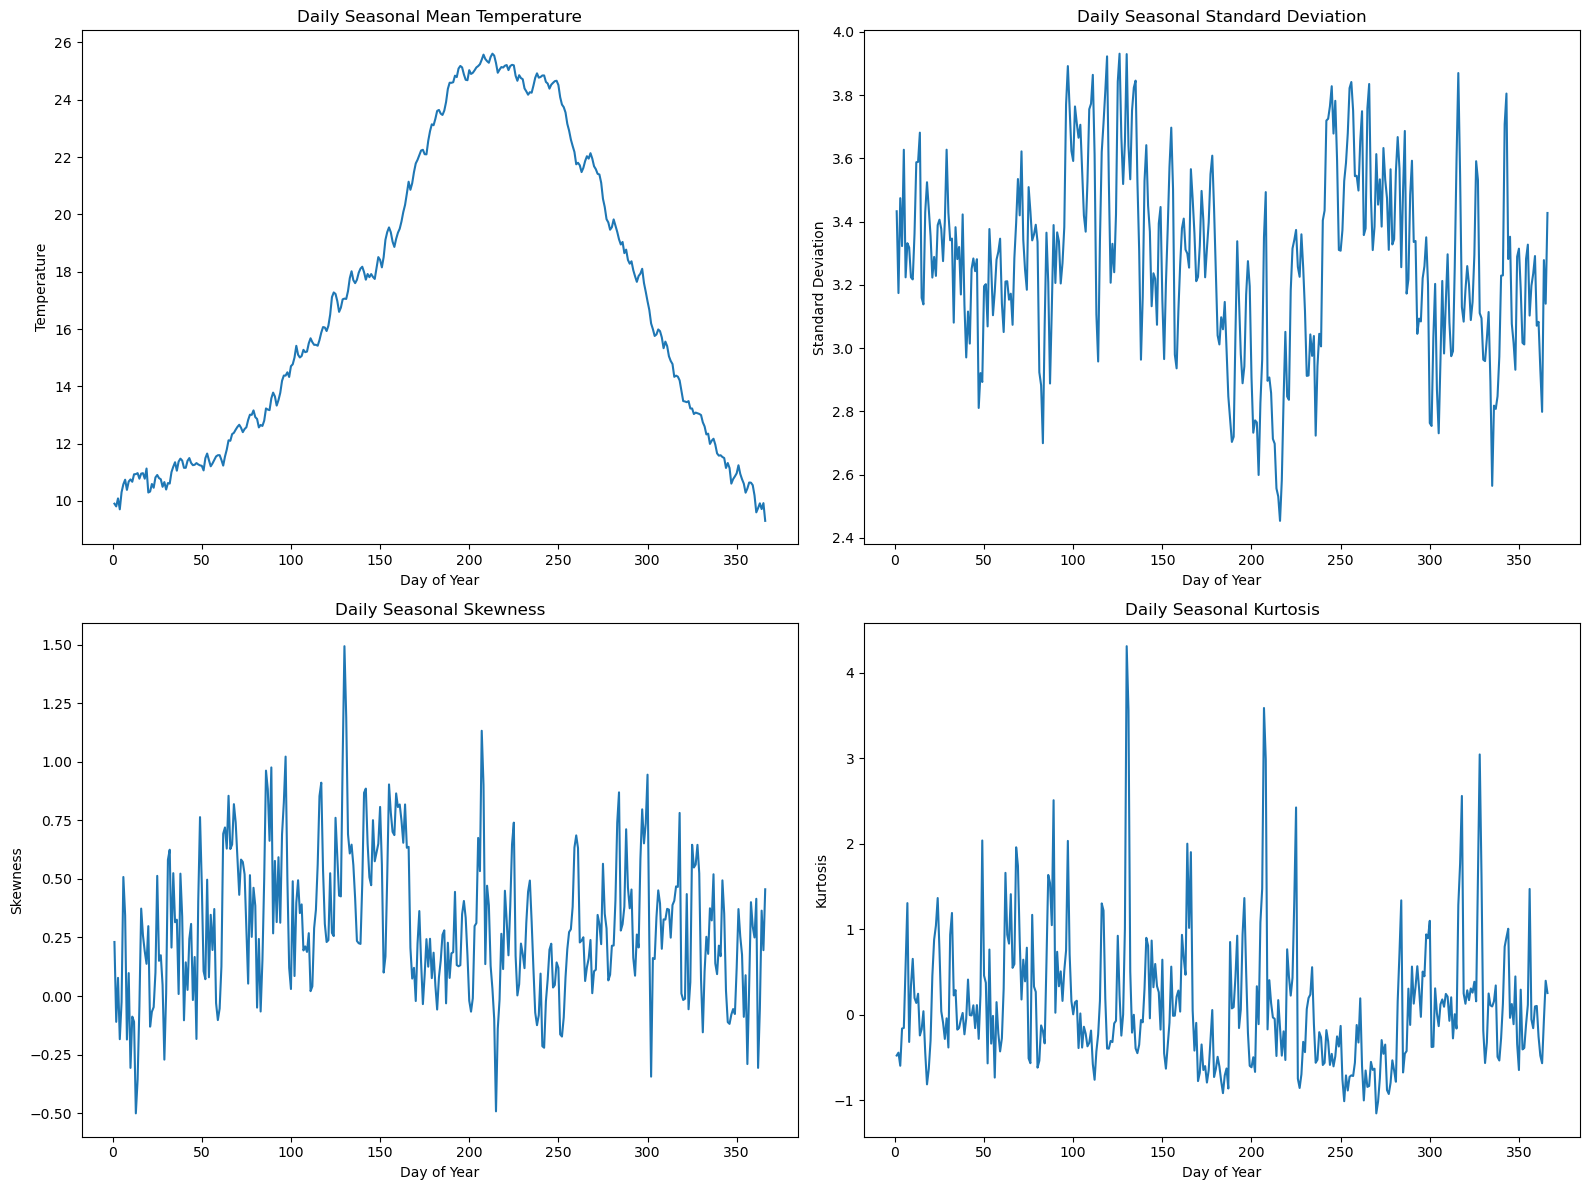

In [3]:
daily_seasonal_mean = temp_data.groupby(temp_data['date'].dt.dayofyear)['mean'].mean()
daily_seasonal_std = temp_data.groupby(temp_data['date'].dt.dayofyear)['mean'].std()
daily_seasonal_skew = temp_data.groupby(temp_data['date'].dt.dayofyear)['mean'].skew()
daily_seasonal_kurtosis = temp_data.groupby(temp_data['date'].dt.dayofyear)['mean'].apply(scipy.stats.kurtosis)

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
daily_seasonal_mean.plot(title='Daily Seasonal Mean Temperature')
plt.xlabel('Day of Year')
plt.ylabel('Temperature')

plt.subplot(2, 2, 2)
daily_seasonal_std.plot(title='Daily Seasonal Standard Deviation')
plt.xlabel('Day of Year')
plt.ylabel('Standard Deviation')

plt.subplot(2, 2, 3)
daily_seasonal_skew.plot(title='Daily Seasonal Skewness')
plt.xlabel('Day of Year')
plt.ylabel('Skewness')

plt.subplot(2, 2, 4)
daily_seasonal_kurtosis.plot(title='Daily Seasonal Kurtosis')
plt.xlabel('Day of Year')
plt.ylabel('Kurtosis')

plt.tight_layout()
plt.show()

# Detrend and deseasonalize (linear)
- Perform ADF and KPSS tests on the raw temperature data.
- Deseasonalize the temperature data by subtracting the daily seasonal mean.
- Perform ADF and KPSS tests on the deseasonalized temperature data.
- Detrend the time series using an OLS regression.
- Deseasonalize and whiten the detrended series.
- Perform ADF and KPSS tests on the deseasonalized and detrended series.
- Estimate the Hurst exponent of the original and processed series.
- Plot the ACF and PACF of the processed series.
      

In [4]:
# Function to perform the ADF test
def adf_test(series, title=''):
    print(f'ADF Test for {title}')
    result = adfuller(series.dropna())
    
    print('ADF Statistic: {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))
    
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}'.format(key, value))
    
    if result[1] <= 0.05:
        print("=> Reject the null hypothesis (H0). The data is stationary.")
    else:
        print("=> Failed to reject the null hypothesis (H0). The data is non-stationary.")
    print("\n")

# Function to perform the KPSS test
def kpss_test(series, title=''):
    print(f'KPSS Test for {title}')
    result = kpss(series.dropna())
    
    print('KPSS Statistic: {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))
    
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t{}: {:.4f}'.format(key, value))
    
    if result[1] <= 0.05:
        print("=> Reject the null hypothesis (H0). The data is non-stationary.")
    else:
        print("=> Failed to reject the null hypothesis (H0). The data is stationary.")
    print("\n")

# Perform tests on raw temperature data
adf_test(temp_data['mean'], "Raw Temperature Data")
kpss_test(temp_data['mean'], "Raw Temperature Data")



ADF Test for Raw Temperature Data
ADF Statistic: -14.6789
p-value: 0.0000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
=> Reject the null hypothesis (H0). The data is stationary.


KPSS Test for Raw Temperature Data
KPSS Statistic: 0.1351
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
=> Failed to reject the null hypothesis (H0). The data is stationary.




/var/folders/8x/z8_ybmwx7tq_c10hj9qc7rx40000gn/T/ipykernel_48643/3327501187.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna())


# WA seasonal mean removal

first we need to prep the data further, removing feb 29 and adding an index 

In [5]:
df = temp_data.copy()

# Remove February 29 to have a consistent 365-day calendar
df['day_of_year'] = df['date'].dt.dayofyear
df = df[~((df['date'].dt.month == 2) & (df['date'].dt.day == 29))]

# Reset index and add t = 1, 2, ..., N
df = df.reset_index(drop=True)
df['t'] = df.index + 1


we estimate and remove the trend: 
We estimate and remove the trend using a linear regression model defined as:

$$\text{Trend}(t) = a + b \cdot t$$

where:
- $a$ is the intercept parameter
- $b$ is the slope parameter (rate of change over time)
- $t$ is the time index (1, 2, ..., n)

This linear trend is estimated using ordinary least squares (OLS) regression and then subtracted from the original temperature series to obtain the detrended data.


Slope: 0.00002
Intercept: 16.72181
t-statistic: 4.55469
p-value: 0.00001


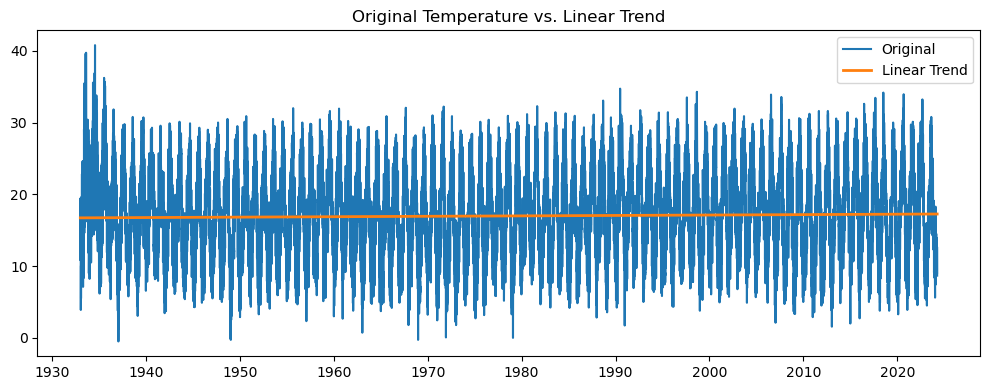

In [6]:
from scipy.stats import linregress

# Extract t and temperature
t = df['t'].values
temp = df['mean'].values

# Fit linear trend and obtain detailed statistics
result = linregress(t, temp)
slope, intercept, r_value, p_value, std_err = result
trend = intercept + slope * t

# Compute t-statistic manually (optional, since p-value is already given by linregress)
t_statistic = slope / std_err

# Print results
print(f"Slope: {slope:.5f}")
print(f"Intercept: {intercept:.5f}")
print(f"t-statistic: {t_statistic:.5f}")
print(f"p-value: {p_value:.5f}")

# Add trend and detrended series to DataFrame
df['trend'] = trend
df['detrended_temp'] = df['mean'] - df['trend']

# Plot to visualize trend
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['mean'], label='Original')
plt.plot(df['date'], df['trend'], label='Linear Trend', linewidth=2)
plt.title('Original Temperature vs. Linear Trend')
plt.legend()
plt.tight_layout()
plt.show()

trend_values = [slope, intercept, r_value, p_value, std_err]

now we decompose the detrended temperature using the Daubechies 11 wavelet

In [7]:

from WA_seasonal_mean import wavelet_decompose

coeff_dict = wavelet_decompose(df['detrended_temp'], wavelet_name='db11')

# Inspect
for key, value in coeff_dict.items():
    print(f"{key}: shape = {value.shape}")


approx: shape = (53,)
detail_1: shape = (16642,)
detail_2: shape = (8331,)
detail_3: shape = (4176,)
detail_4: shape = (2098,)
detail_5: shape = (1059,)
detail_6: shape = (540,)
detail_7: shape = (280,)
detail_8: shape = (150,)
detail_9: shape = (85,)
detail_10: shape = (53,)


In [8]:
import ipywidgets as widgets
from ipywidgets import interact
from WA_seasonal_mean import wavelet_reconstruct

def plot_single_detail(level, coeff_dict):
    single_detail_signal = wavelet_reconstruct(
        coeff_dict,
        keep_levels=[f'detail_{level}'],  # only this detail
        wavelet_name='db11'
    )
    
    plt.figure(figsize=(10, 4))
    plt.plot(single_detail_signal, label=f'Detail {level}')
    plt.title(f"Reconstructed Wavelet Detail {level}")
    plt.legend()
    plt.show()


interact(
    plot_single_detail,
    level=widgets.IntSlider(min=1, max=10, step=1, value=1, description='Detail Level',),
    coeff_dict=widgets.fixed(coeff_dict),
);


interactive(children=(IntSlider(value=1, description='Detail Level', max=10, min=1), Output()), _dom_classes=(…

<Figure size 1500x1000 with 0 Axes>

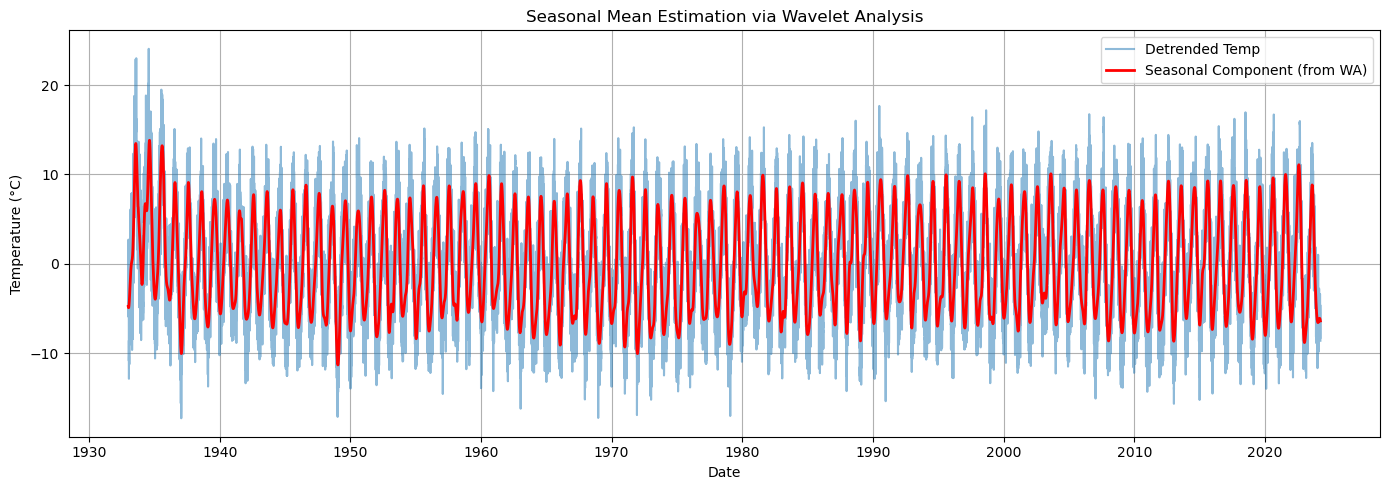

In [9]:
from WA_seasonal_mean import wavelet_reconstruct

keep = ['approx',  'detail_11', 'detail_10', 'detail_9', 'detail_8', 'detail_7']   
# Reconstruct seasonal component
seasonal_component = wavelet_reconstruct(coeff_dict, keep, wavelet_name='db11')
# Add this code to visualize each wavelet detail level separately
plt.figure(figsize=(15, 10))

# Add to DataFrame
df['seasonal'] = seasonal_component[:len(df)]  # match original length in case of rounding

# Plot to visualize seasonal component
plt.figure(figsize=(14, 5))

plt.plot(df['date'], df['detrended_temp'], label='Detrended Temp', alpha=0.5)
plt.plot(df['date'], df['seasonal'], label='Seasonal Component (from WA)', color='red', linewidth=2)

plt.title('Seasonal Mean Estimation via Wavelet Analysis')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

let's have a clearer idea by plotting just last 5 years

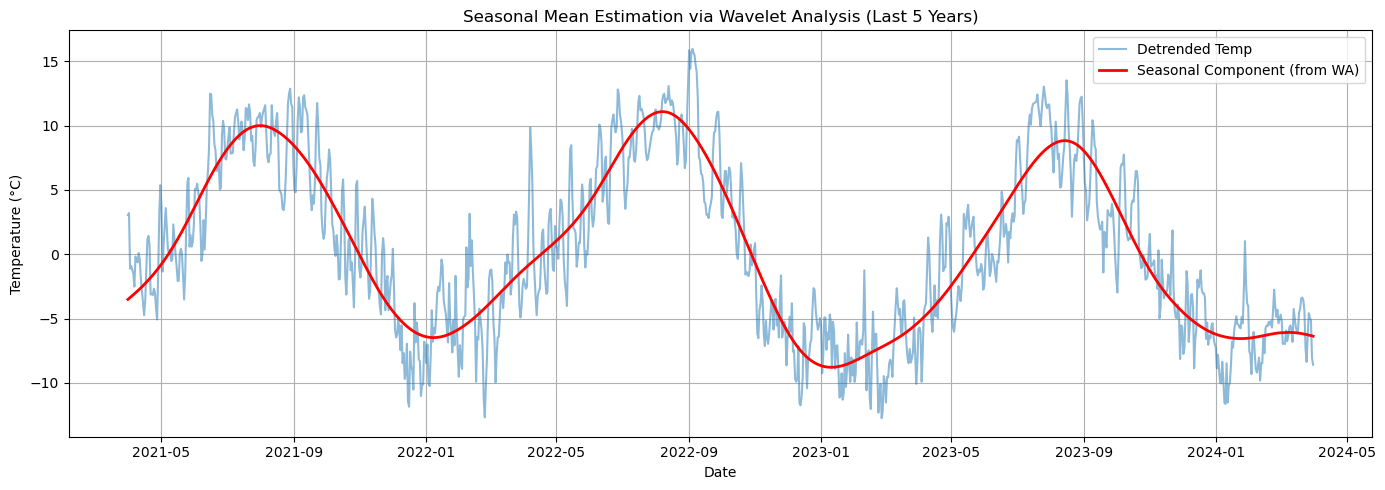

In [10]:
# Define the last 5-year window
end_date = df['date'].max()
start_date = end_date - pd.DateOffset(years=3)

# Filter the DataFrame
df_last5 = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Plot to visualize seasonal component for the last 5 years
plt.figure(figsize=(14, 5))

plt.plot(df_last5['date'], df_last5['detrended_temp'], label='Detrended Temp', alpha=0.5)
plt.plot(df_last5['date'], df_last5['seasonal'], label='Seasonal Component (from WA)', color='red', linewidth=2)

plt.title('Seasonal Mean Estimation via Wavelet Analysis (Last 5 Years)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

let's compute the sinusoid

$$\mathcal{S}(t) = \sum_{i=1}^{n} a_i \cdot \sin\left( \frac{2\pi (t - \phi_i)}{p_i} \right)$$

Where:
*   $t$ is the day index
*   $a_i$: amplitude (to be fitted)
*   $\phi_i$: phase shift (to be fitted)
*   $p_i$: period in days (fixed from wavelet inspection)

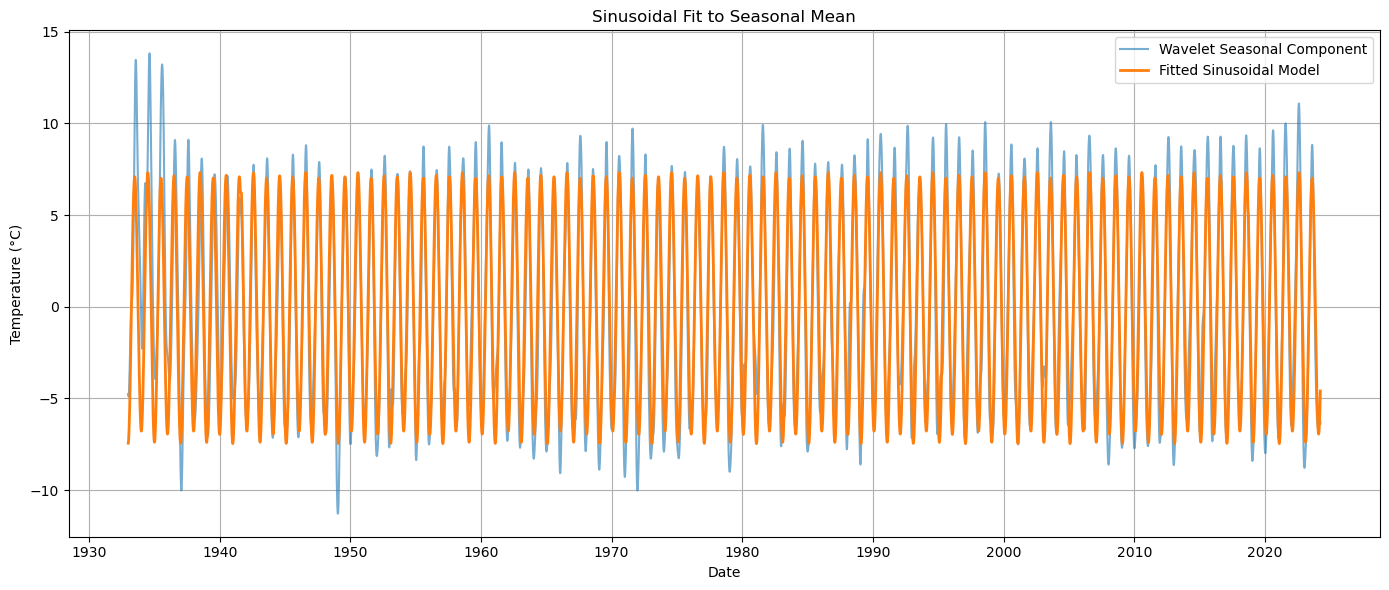

Cycle 1: Amplitude = 7.155, Phase Shift = 87.12, Period = 365 days
Cycle 2: Amplitude = 0.293, Phase Shift = 217.83, Period = 730 days
Cycle 3: Amplitude = 0.090, Phase Shift = 81.10, Period = 1460 days


In [11]:

from scipy.optimize import curve_fit

# Step 1: Define the periods corresponding to detail_3, 4, 5
# You can fine-tune these later based on analysis or trial-error
periods = [365, 730, 1460]  # approx: 1 year, 2 years, 4 years

# Step 2: Define the sinusoidal model with these 3 fixed periods
def seasonal_model(t, a1, phi1, a2, phi2, a3, phi3, a4, phi4):
    p1, p2, p3 = 365, 730, 1460
    p4 = 2920  # ~8 years (modulation period)

    modulated = a4 * (1 + np.sin(2 * np.pi * (t - phi4) / p4)) * np.sin(2 * np.pi * t / 365)

    return (
        a1 * np.sin(2 * np.pi * (t - phi1) / p1) +
        a2 * np.sin(2 * np.pi * (t - phi2) / p2) +
        a3 * np.sin(2 * np.pi * (t - phi3) / p3) +
        modulated
    )

# Step 3: Prepare the data for fitting
t = df['t'].values
y = df['seasonal'].values

# Initial guesses for [a1, phi1, a2, phi2, a3, phi3]
initial_guess = [10, 100, 5, 200, 2, 300, 2, 400]
# Step 4: Fit the sinusoidal model
popt, pcov = curve_fit(seasonal_model, t, y, p0=initial_guess)

# Generate fitted seasonal values
df['fitted_seasonal'] = seasonal_model(t, *popt)

# Step 5: Plot the result
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['seasonal'], label='Wavelet Seasonal Component', alpha=0.6)
plt.plot(df['date'], df['fitted_seasonal'], label='Fitted Sinusoidal Model', linewidth=2)
plt.title("Sinusoidal Fit to Seasonal Mean")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Print the fitted parameters
for i in range(3):
    amp = popt[2*i]
    phase = popt[2*i + 1]
    print(f"Cycle {i+1}: Amplitude = {amp:.3f}, Phase Shift = {phase:.2f}, Period = {periods[i]} days")


sinusoidal_params = popt[:6]  # Extract the first 6 parameters

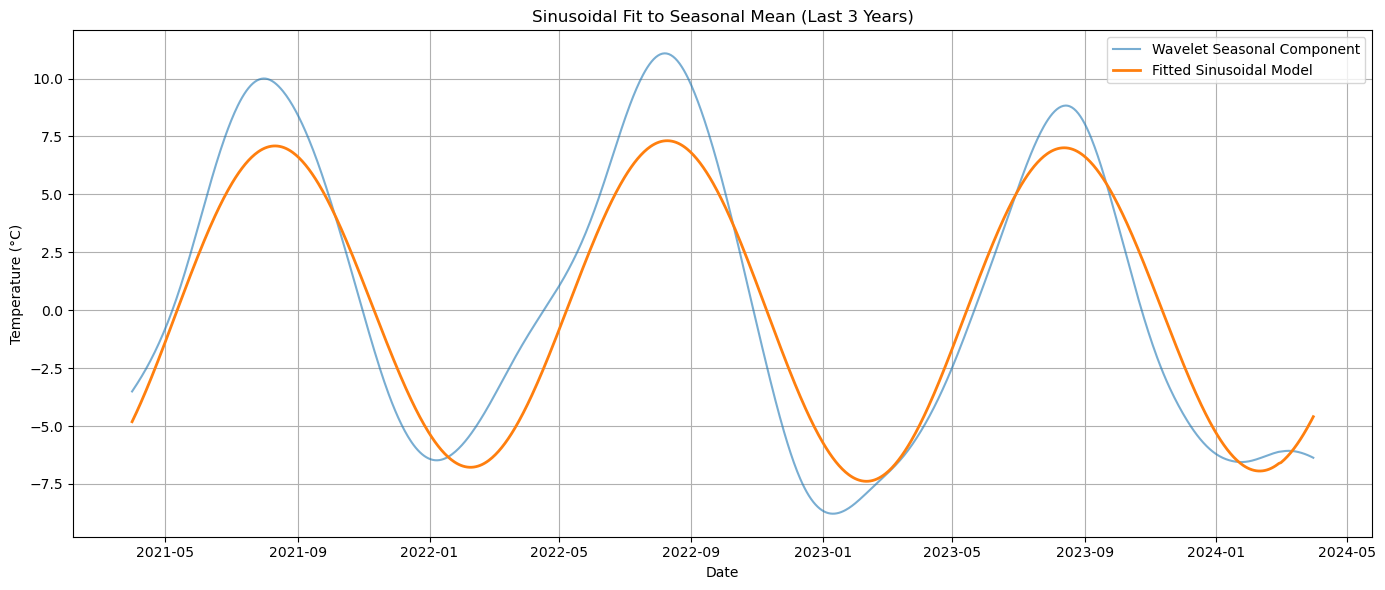

In [12]:
# Plot the last 3 years window
# Calculate the date 3 years before the last date
last_date = df['date'].max()
three_years_ago = last_date - pd.DateOffset(years=3)

# Filter the DataFrame
df_last_3years = df[df['date'] >= three_years_ago]

# Create the plot
plt.figure(figsize=(14, 6))
plt.plot(df_last_3years['date'], df_last_3years['seasonal'], label='Wavelet Seasonal Component', alpha=0.6)
plt.plot(df_last_3years['date'], df_last_3years['fitted_seasonal'], label='Fitted Sinusoidal Model', linewidth=2)
plt.title("Sinusoidal Fit to Seasonal Mean (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
df['residual'] = df['detrended_temp'] - df['fitted_seasonal']

# STOPPED HERE

In [14]:
'''
from hurst import compute_Hc

# Unit root tests on the deseasonalized and detrended series
adf_test(deseasonalized_detrended, "Deseasonalized and Detrended Temperature Data")
kpss_test(deseasonalized_detrended, "Deseasonalized and Detrended Temperature Data")

# Hurst exponent estimation
H, c, val = compute_Hc(temp_data['temp'], kind='change', simplified=True)
print(f"Hurst exponent of original series: {H:.4f}")

H_processed, c_processed, val_processed = compute_Hc(deseasonalized_detrended.dropna(), kind='change', simplified=True)
print(f"Hurst exponent of processed series: {H_processed:.4f}")

# Autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(deseasonalized_detrended.dropna(), lags=50, ax=plt.gca())
plt.title('ACF of Deseasonalized and Detrended Temperature Data')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(deseasonalized_detrended.dropna(), lags=50, ax=plt.gca())
plt.title('PACF of Deseasonalized and Detrended Temperature Data')
plt.show()

# Optional: Visualize the original vs. detrended vs. fully processed data
plt.figure(figsize=(14, 8))
plt.plot(temp_data['date'], temp_data['temp'], label='Original Temperature')
plt.plot(temp_data['date'], detrended, label='Detrended Temperature')
plt.plot(temp_data_with_day['date'], deseasonalized_detrended, label='Detrended & Deseasonalized')
plt.title('Temperature Data Processing Comparison')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()
'''

'\nfrom hurst import compute_Hc\n\n# Unit root tests on the deseasonalized and detrended series\nadf_test(deseasonalized_detrended, "Deseasonalized and Detrended Temperature Data")\nkpss_test(deseasonalized_detrended, "Deseasonalized and Detrended Temperature Data")\n\n# Hurst exponent estimation\nH, c, val = compute_Hc(temp_data[\'temp\'], kind=\'change\', simplified=True)\nprint(f"Hurst exponent of original series: {H:.4f}")\n\nH_processed, c_processed, val_processed = compute_Hc(deseasonalized_detrended.dropna(), kind=\'change\', simplified=True)\nprint(f"Hurst exponent of processed series: {H_processed:.4f}")\n\n# Autocorrelation plots\nfrom statsmodels.graphics.tsaplots import plot_acf, plot_pacf\n\nplt.figure(figsize=(12, 6))\nplot_acf(deseasonalized_detrended.dropna(), lags=50, ax=plt.gca())\nplt.title(\'ACF of Deseasonalized and Detrended Temperature Data\')\nplt.show()\n\nplt.figure(figsize=(12, 6))\nplot_pacf(deseasonalized_detrended.dropna(), lags=50, ax=plt.gca())\nplt.titl

# Estimating the Mean Reversion Speed

Build lagged dataset

In [15]:
from WA_mean_reversion_speed import build_lagged_dataset

max_lag = 10
X, y = build_lagged_dataset(df['residual'], max_lag=max_lag)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (33253, 10)
Shape of y: (33253,)


Split dataset

In [16]:
from WA_mean_reversion_speed import train_test_split

# NB book suggests a time-wise split, so shuffle=False
test_size = 0.2  # 20% of data for test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=test_size, shuffle=False
)
# Further split train_val => train & val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=False
)

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

Train size: 21281, Val size: 5321, Test size: 6651


Model initialization and training

In [17]:
from WA_mean_reversion_speed import WaveletNetwork, train_model

# Instantiate a WaveletNetwork
input_dim = X_train.shape[1]
hidden_dim = 20  # number of wavelets in the hidden layer
wavelet_type = 'mexh'  # or 'morlet'

model = WaveletNetwork(input_dim, hidden_dim, output_dim=1, wavelet=wavelet_type)
print("Created WaveletNetwork with input_dim =", input_dim)

# 5. Train the model
epochs = 1000
history = train_model(
    model,
    X_train, y_train,
    X_val, y_val,
    epochs=epochs,
    batch_size=128,
    lr=0.001
)
print("\nDone training!")


Created WaveletNetwork with input_dim = 10
Epoch 100/1000, Train Loss: 3.492429, Val Loss: 3.161258
Epoch 200/1000, Train Loss: 3.395912, Val Loss: 3.144625
Epoch 300/1000, Train Loss: 3.364843, Val Loss: 3.140653
Epoch 400/1000, Train Loss: 3.347537, Val Loss: 3.142429
Epoch 500/1000, Train Loss: 3.334507, Val Loss: 3.134912
Epoch 600/1000, Train Loss: 3.321008, Val Loss: 3.149154
Epoch 700/1000, Train Loss: 3.325593, Val Loss: 3.131297
Epoch 800/1000, Train Loss: 3.316429, Val Loss: 3.139709
Epoch 900/1000, Train Loss: 3.322928, Val Loss: 3.139037
Epoch 1000/1000, Train Loss: 3.323643, Val Loss: 3.140142

Done training!


Sensitivy based pruning

In [18]:
from WA_mean_reversion_speed import sensitivity_based_pruning

X_train_tensor = torch.FloatTensor(X_train)
significant_lags, sensitivities = sensitivity_based_pruning(model, X_train_tensor, threshold=0.01)
print("\nSignificant Lags (indices):", significant_lags)
print("Raw normalized sensitivities:", sensitivities)


Significant Lags (indices): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Raw normalized sensitivities: [1.         0.40232813 0.26801338 0.25907508 0.28929974 0.34940276
 0.15859932 0.29419022 0.20800415 0.34854035]


Evaluation

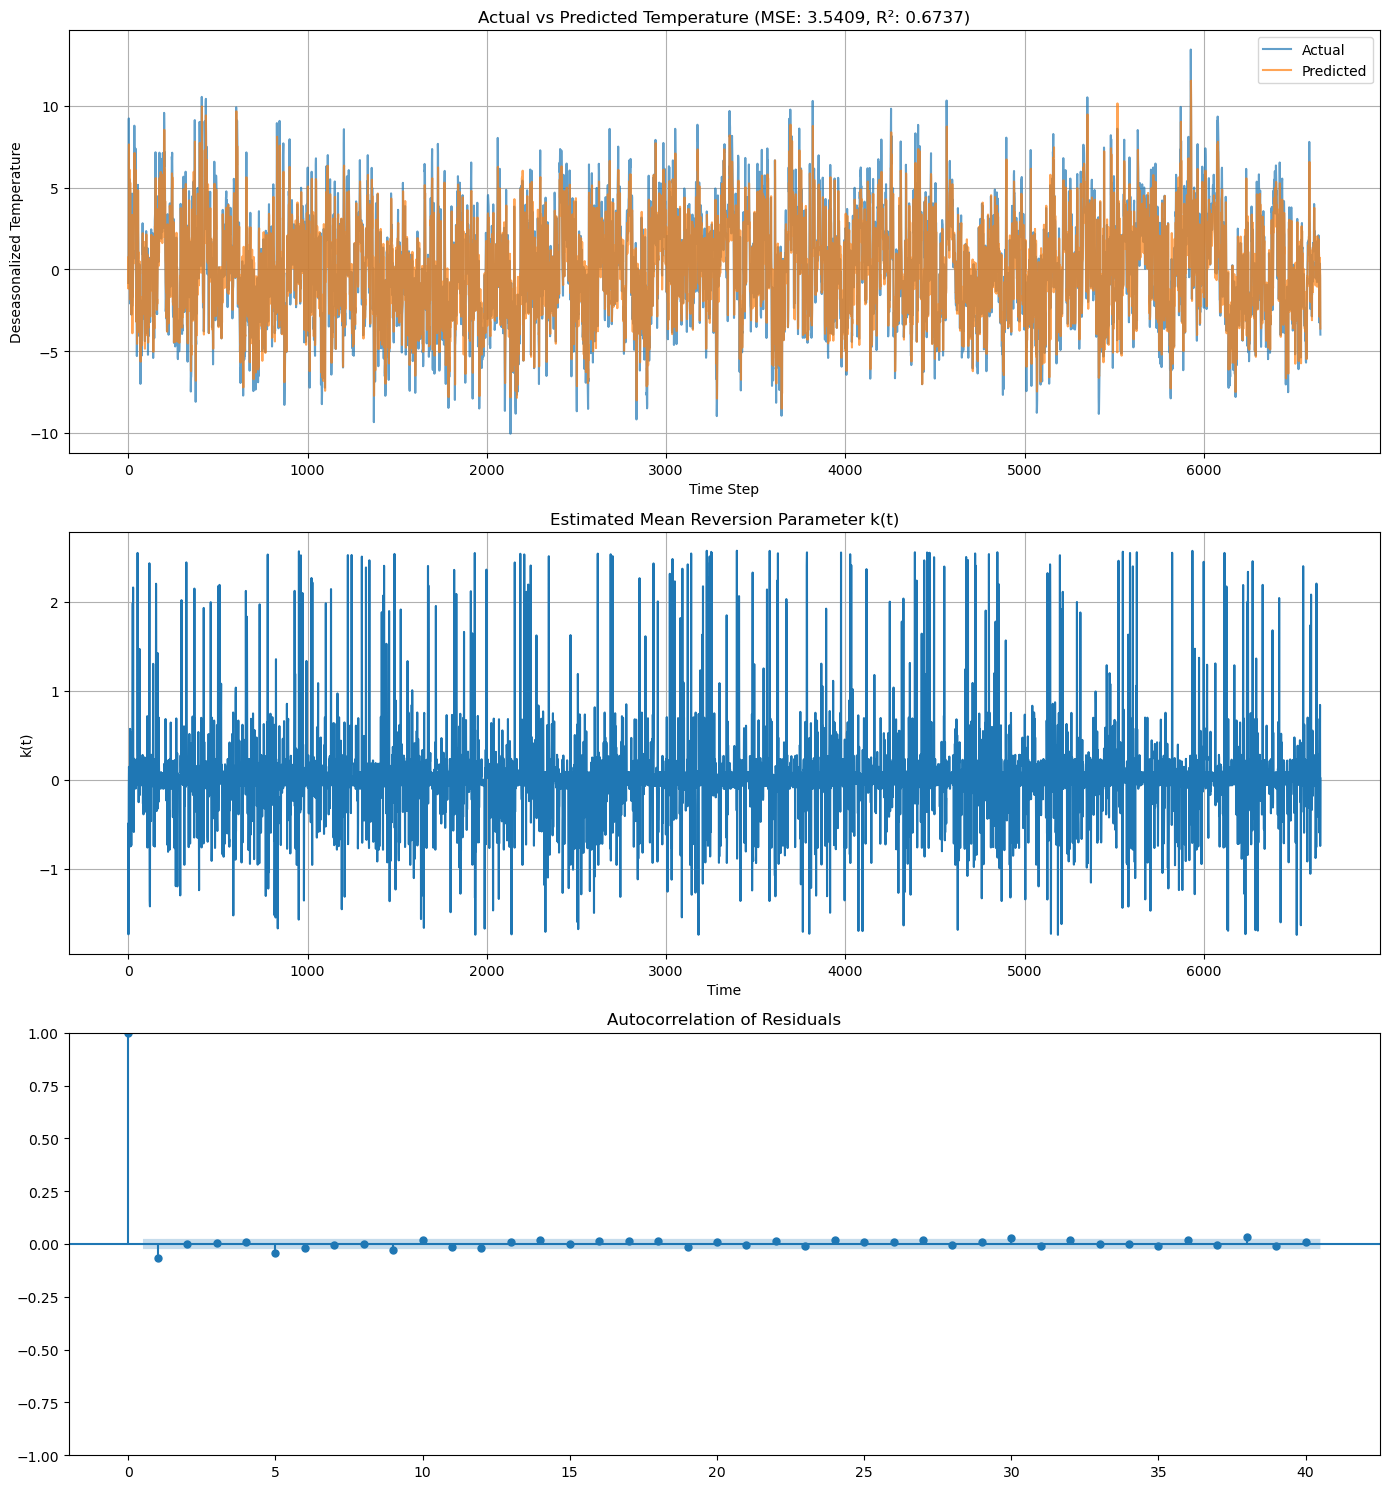

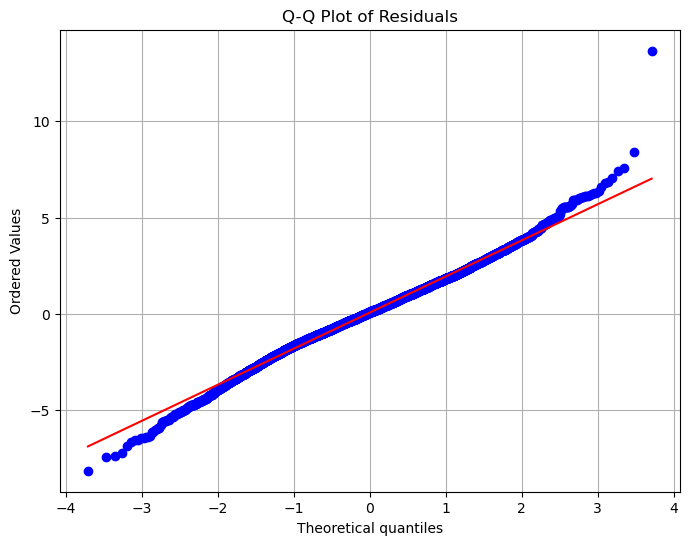

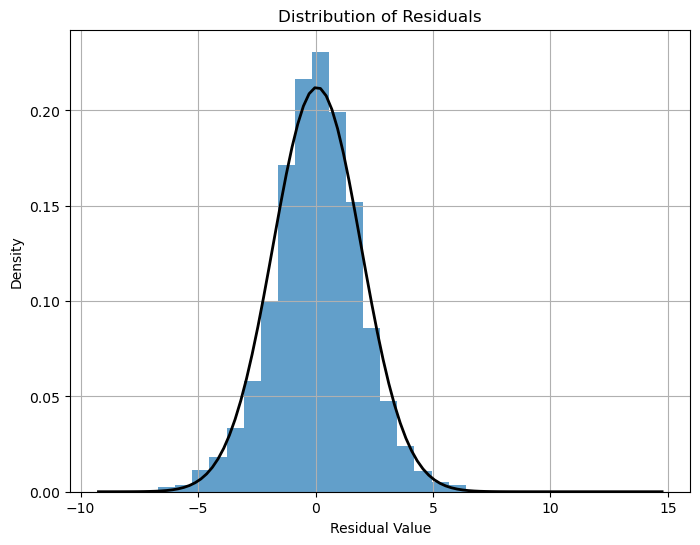


Test Set Evaluation:
MSE: 3.540872001420209
R2 : 0.6736689127306275
Mean k(t): 0.04166593249042022
Std  k(t): 0.48300962216224413


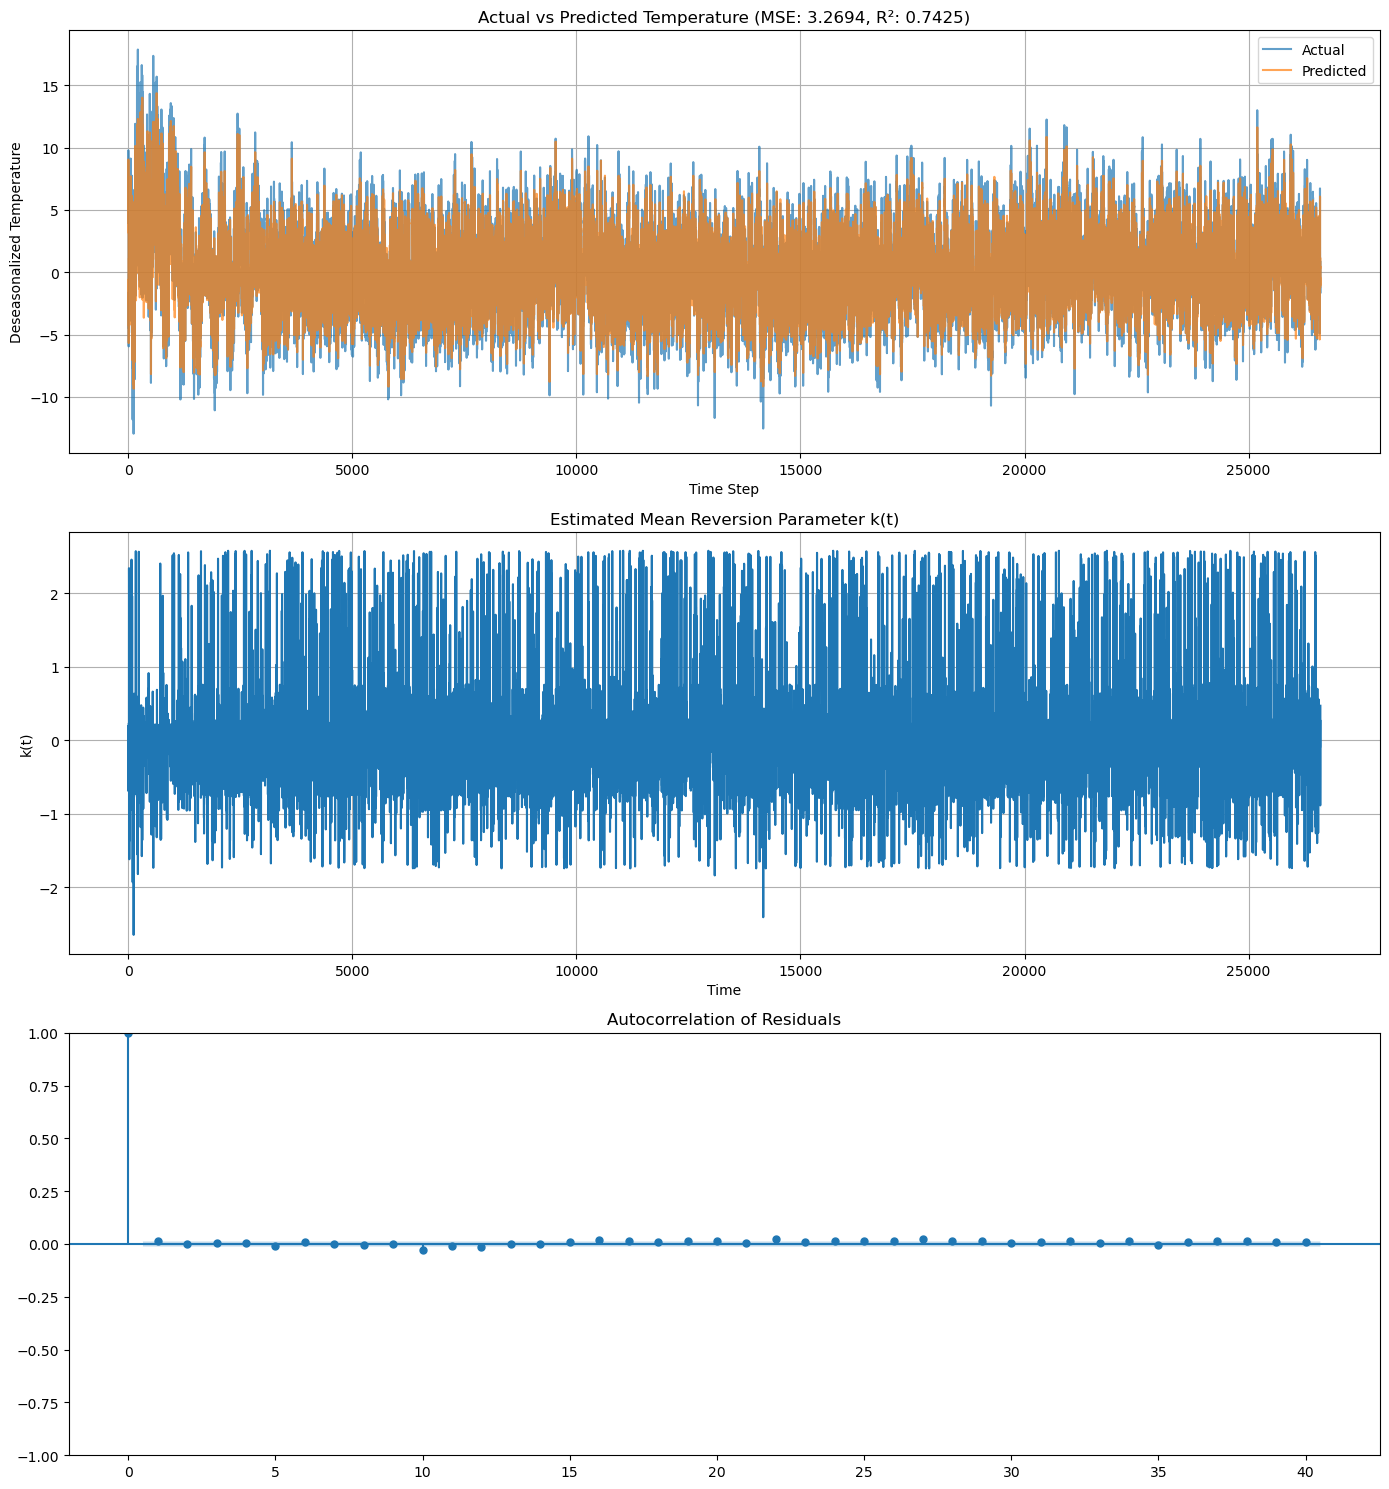

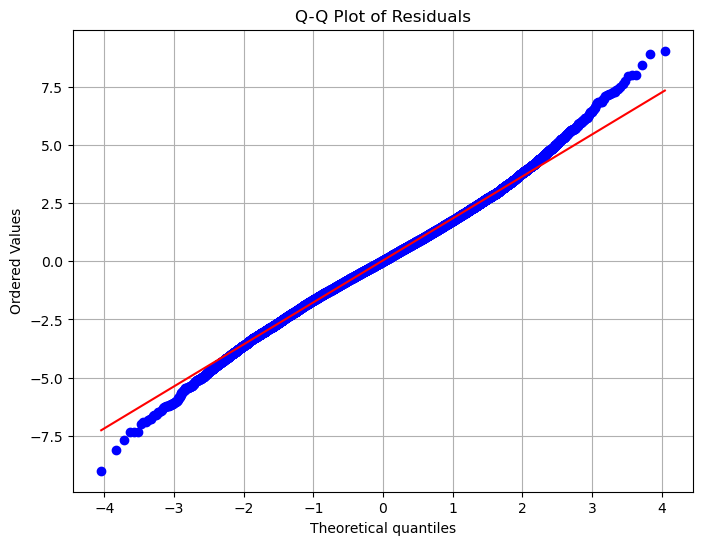

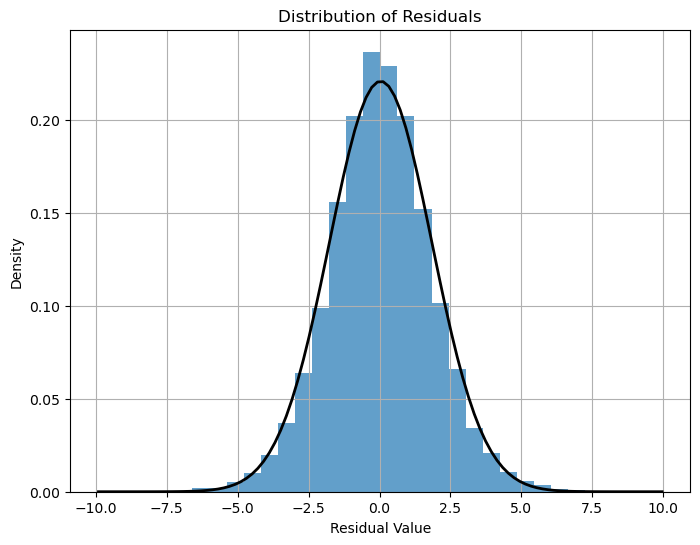

In [19]:
from WA_mean_reversion_speed import evaluate_model

metrics_test, predictions_test, k_values_test, residuals_test = evaluate_model(model, X_test, y_test)
print("\nTest Set Evaluation:")
print("MSE:", metrics_test['mse'])
print("R2 :", metrics_test['r2'])
print("Mean k(t):", metrics_test['mean_k'])
print("Std  k(t):", metrics_test['std_k'])


metrics_train, predictions_train, k_values_train, residuals_train = evaluate_model(model, X_train_val, y_train_val)

# Combine outputs
all_predictions = np.concatenate([predictions_train, predictions_test])
all_k = np.concatenate([k_values_train, k_values_test])
all_residuals = np.concatenate([residuals_train, residuals_test])
all_y = np.concatenate([y_train, y_test])
all_X = np.concatenate([X_train, X_test])

# Trim old data set
df = df.iloc[:len(all_k)]

# Add predictions, k(t) to the DataFrame
df['k_t'] = all_k

Plot model diagnostics

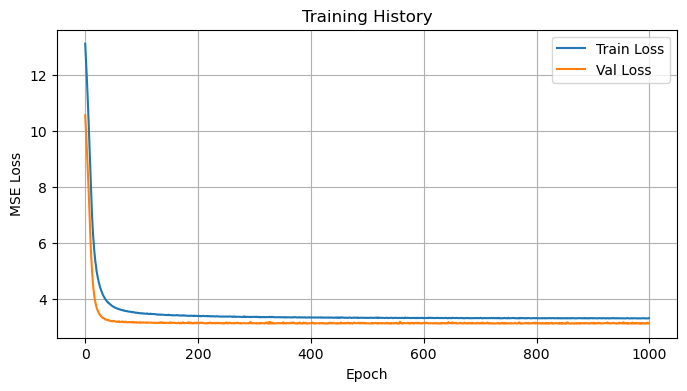

In [20]:
plt.figure(figsize=(8,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

# Volatility modeling

We perform a Kolmogorov test to check if residuals are normal and a Ljung-Box lack of fit test to check if residuals are random or not

Kolmogorov-Smirnov Test for Normality of Residuals
KS Statistic: 0.0193
p-value: 0.0000
=> Reject the null hypothesis. The residuals are not normally distributed.


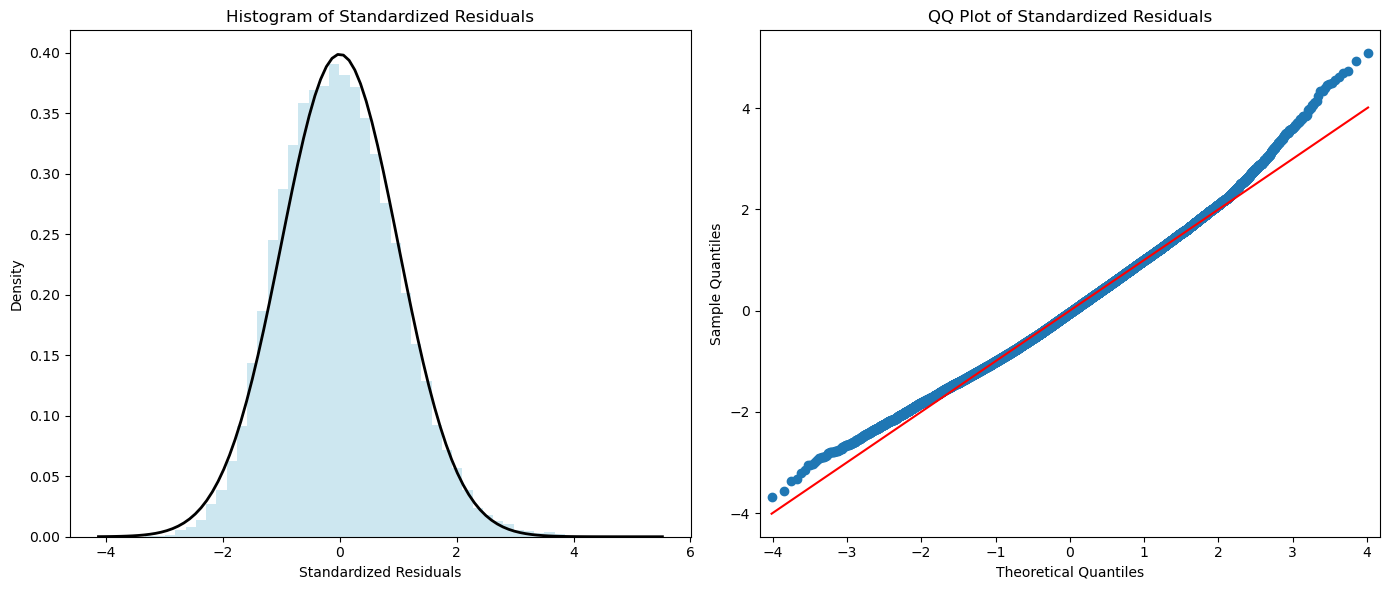


Ljung-Box Test for Autocorrelation of Residuals
         lb_stat  lb_pvalue
1   23628.893096        0.0
5   54604.089035        0.0
10  67236.932383        0.0
15  76350.198564        0.0
20  83453.162081        0.0
30  94771.945989        0.0

Interpretation:
Lag 1: Reject the null hypothesis - There is significant autocorrelation.
Lag 5: Reject the null hypothesis - There is significant autocorrelation.
Lag 10: Reject the null hypothesis - There is significant autocorrelation.
Lag 15: Reject the null hypothesis - There is significant autocorrelation.
Lag 20: Reject the null hypothesis - There is significant autocorrelation.
Lag 30: Reject the null hypothesis - There is significant autocorrelation.


<Figure size 1000x600 with 0 Axes>

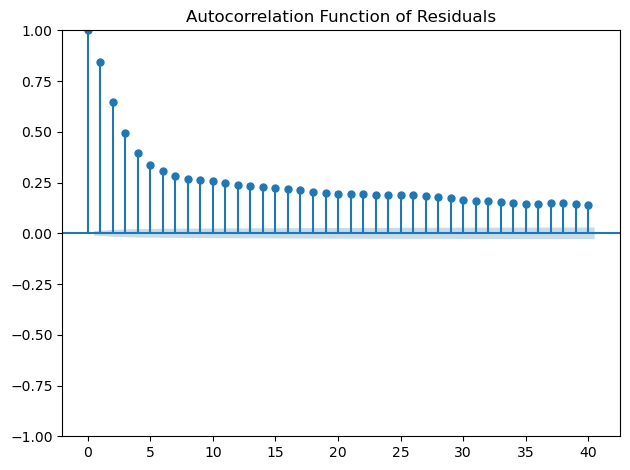

In [ ]:
# Import necessary libraries
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.gofplots import qqplot
import pandas as pd

# ---------- Kolmogorov-Smirnov Test for Normality ----------
print("Kolmogorov-Smirnov Test for Normality of Residuals")
residuals = df['residual'].dropna().values
# Standardize residuals (zero mean, unit variance)
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
ks_statistic, ks_pvalue = stats.kstest(standardized_residuals, 'norm')

print(f"KS Statistic: {ks_statistic:.4f}")
print(f"p-value: {ks_pvalue:.4f}")

if ks_pvalue <= 0.05:
    print("=> Reject the null hypothesis. The residuals are not normally distributed.")
else:
    print("=> Failed to reject the null hypothesis. The residuals appear to be normally distributed.")

# Visual assessment of normality
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(standardized_residuals, bins=50, density=True, alpha=0.6, color='lightblue')
# Add a normal density curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, 0, 1)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Histogram of Standardized Residuals')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
qqplot(standardized_residuals, line='s', ax=plt.gca())
plt.title('QQ Plot of Standardized Residuals')
plt.tight_layout()
plt.show()

# ---------- Ljung-Box Test for Autocorrelation ----------
print("\nLjung-Box Test for Autocorrelation of Residuals")
# Test for different lags
lags = [1, 5, 10, 15, 20, 30]

# Handle different versions of statsmodels
try:
    # Try with return_df=True (newer versions of statsmodels)
    lb_results = acorr_ljungbox(residuals, lags=lags, return_df=True)
    
    # Check if 'lb_pvalue' and 'lb_stat' exist, if not, rename 'model_qstat' and 'model_pvalue'
    if 'lb_pvalue' not in lb_results.columns and 'lb_stat' not in lb_results.columns:
        lb_results = lb_results.rename(columns={'model_qstat': 'lb_stat', 'model_pvalue': 'lb_pvalue'})
    
    # Already a DataFrame, just print it
    print(lb_results)
    print("\nInterpretation:")
    for lag in lags:
        # Find the row for this lag
        # Use .loc to find the row where 'lag' column equals the current lag
        # Check if 'lag' column exists, if not, create it
        if 'lag' not in lb_results.columns:
            lb_results['lag'] = lags[:len(lb_results)]  # Ensure 'lags' is not longer than lb_results
        row = lb_results.loc[lb_results['lag'] == lag]
       
        if not row.empty:
            p_value = row['lb_pvalue'].values[0]
            if p_value <= 0.05:
                print(f"Lag {lag}: Reject the null hypothesis - There is significant autocorrelation.")
            else:
                print(f"Lag {lag}: Failed to reject the null hypothesis - No significant autocorrelation.")
        else:
            print(f"Lag {lag}: Not found in Ljung-Box test results.")
        
except (TypeError, ValueError):
    # Fall back to older statsmodels version
    lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=lags)
    
    # Create a DataFrame for better visualization
    lb_df = pd.DataFrame({
        'Lag': lags,
        'Test Statistic': lb_stat,
        'p-value': lb_pvalue
    })
    
    print(lb_df)
    print("\nInterpretation:")
    for idx, lag in enumerate(lags):
        if lb_pvalue[idx] <= 0.05:
            print(f"Lag {lag}: Reject the null hypothesis - There is significant autocorrelation.")
        else:
            print(f"Lag {lag}: Failed to reject the null hypothesis - No significant autocorrelation.")

# Visual assessment of autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=100, alpha=0.05, title='Autocorrelation Function of Residuals')
plt.tight_layout()
plt.show()

To model the variance, we work with squared residuals:

$$
Y(t) = \left( T(t) - S(t) \right)^2 = X(t)^2 \approx \sigma^2(t)

In [22]:
df['squared_residual'] = df['residual']**2

In [23]:
print(len(df['squared_residual']))
df.head()

33253


,date,mean,max,min,day_of_year,t,trend,detrended_temp,seasonal,fitted_seasonal,residual,k_t,squared_residual
0,1933-01-01,13.67,18.89,2.78,1,1,16.721826,-3.051826,-4.756824,-7.439673,4.387847,-0.091276,19.253197
1,1933-01-02,13.89,19.61,1.89,2,2,16.721842,-2.831842,-4.784417,-7.428960,4.597118,0.075272,21.133491
2,1933-01-03,10.83,16.28,0.78,3,3,16.721858,-5.891858,-4.809023,-7.416127,1.524269,-0.046065,2.323395
3,1933-01-04,14.94,21.28,1.28,4,4,16.721875,-1.781875,-4.830577,-7.401178,5.619304,0.195095,31.576576
4,1933-01-05,18.11,23.50,6.89,5,5,16.721891,1.388109,-4.849012,-7.384118,8.772227,0.154031,76.951975


let's plot them:

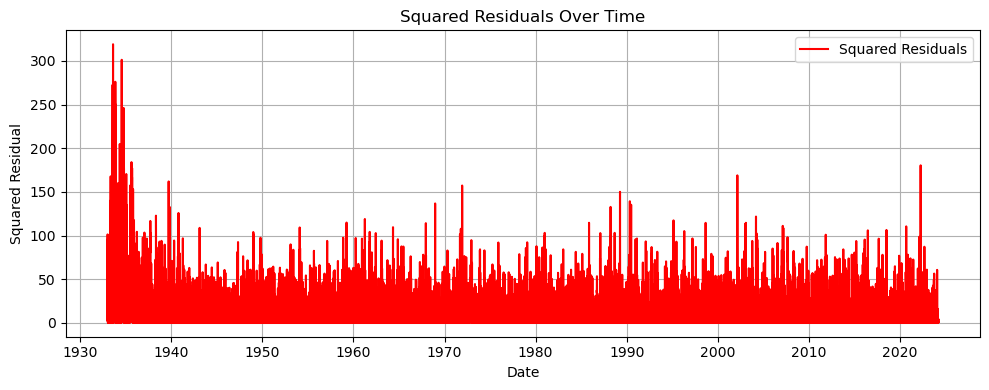

In [24]:
# Plot the squared residuals
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['squared_residual'], color='red', label='Squared Residuals')
plt.title("Squared Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Squared Residual")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

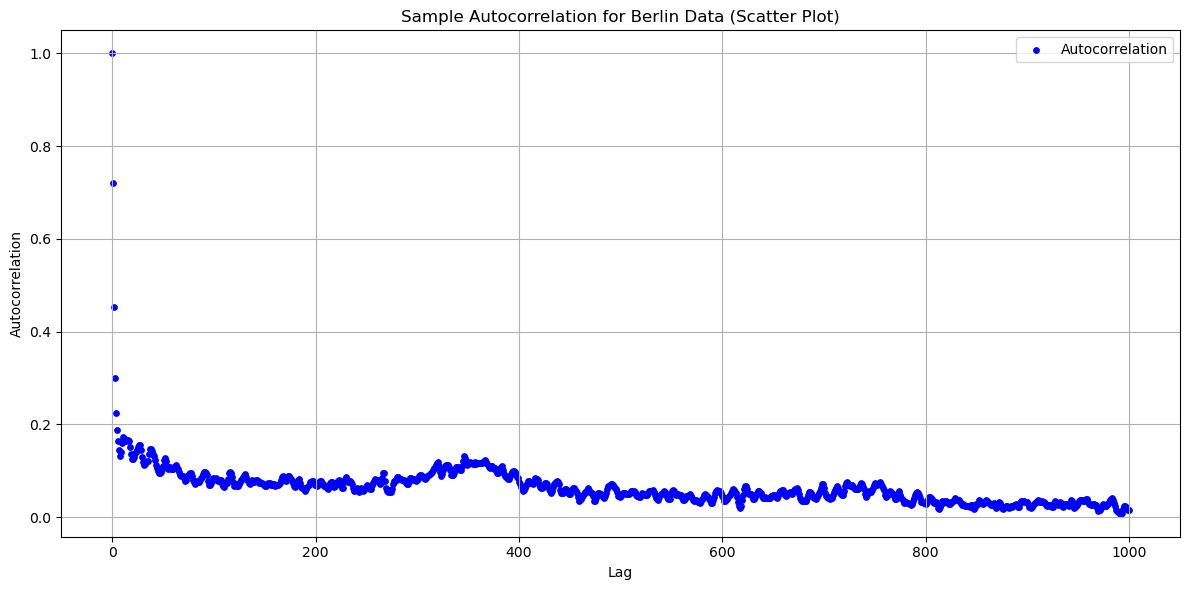

In [25]:
from statsmodels.tsa.stattools import acf

data = df['squared_residual'].values

# Compute the autocorrelation for lags 
nlags = 1000
autocorr_vals = acf(data, nlags=nlags)

# Create an array of lags from 0 to 1000
lags = np.arange(nlags+1)

# Plot using a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(lags, autocorr_vals, color='blue', s=15, label='Autocorrelation')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Sample Autocorrelation for Berlin Data (Scatter Plot)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The volatility is also seasonal (e.g. winter more volatile than summer). So we do a wavelet decomposition of the squared residuals and reconstruct the seasonal part using appropriate detail levels. Essentialy we repeat what we did in the seasonal mean part

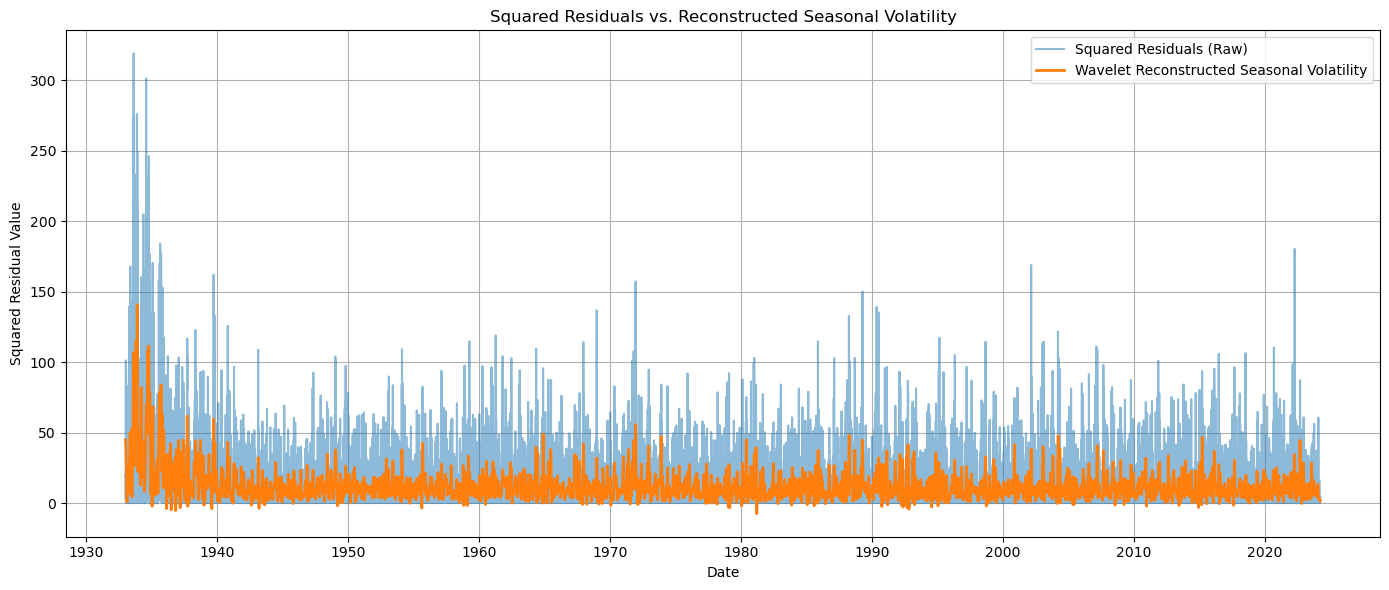

In [26]:
from WA_seasonal_mean import wavelet_decompose, wavelet_reconstruct

# ---------- Step 1: Wavelet Decomposition and Reconstruction of Squared Residuals ----------

# Decompose the squared residuals using wavelets (example with Daubechies 11)
vol_coeffs = wavelet_decompose(df['squared_residual'], wavelet_name='db11')

# Choose selected levels to capture the seasonal volatility structure.
# Here we choose the approximation plus details 3, 4, and 5.
keep_vol = ['approx', 'detail_11', 'detail_10', 'detail_9', 'detail_8', 'detail_7', 'detail_6', 'detail_5']

# Reconstruct the seasonal volatility component from these levels.
volatility_seasonal = wavelet_reconstruct(vol_coeffs, keep_vol, wavelet_name='db11')
df['seasonal_volatility'] = volatility_seasonal[:len(df)]  # Ensure matching length

# ---------- Step 2: Plot the Squared Residuals and the Reconstructed Seasonal Volatility ----------

plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['squared_residual'], label='Squared Residuals (Raw)', alpha=0.5)
plt.plot(df['date'], df['seasonal_volatility'], label='Wavelet Reconstructed Seasonal Volatility', linewidth=2)
plt.title("Squared Residuals vs. Reconstructed Seasonal Volatility")
plt.xlabel("Date")
plt.ylabel("Squared Residual Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


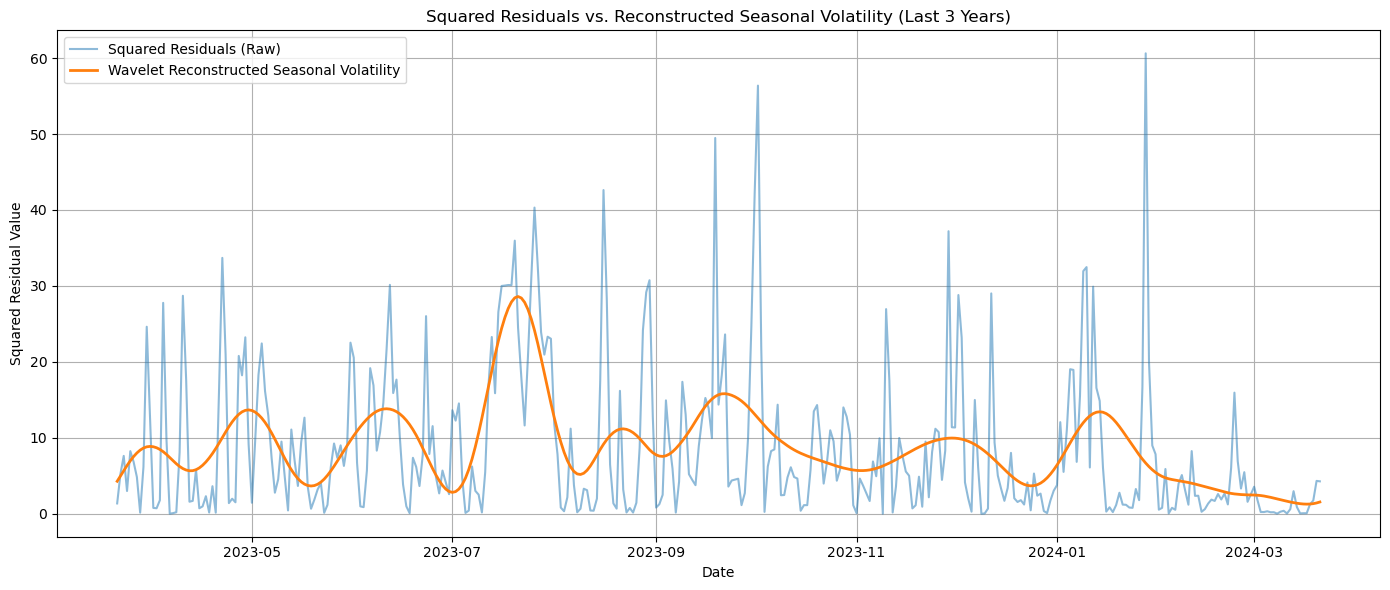

In [27]:
# Plot for the last 3 years
# Calculate the date range
last_date = df['date'].max()
three_years_ago = last_date - pd.DateOffset(years=1)

# Filter the DataFrame
df_last_3years = df[df['date'] >= three_years_ago]

# Create the plot
plt.figure(figsize=(14, 6))
plt.plot(df_last_3years['date'], df_last_3years['squared_residual'], 
         label='Squared Residuals (Raw)', alpha=0.5)
plt.plot(df_last_3years['date'], df_last_3years['seasonal_volatility'], 
         label='Wavelet Reconstructed Seasonal Volatility', linewidth=2)
plt.title("Squared Residuals vs. Reconstructed Seasonal Volatility (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Squared Residual Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

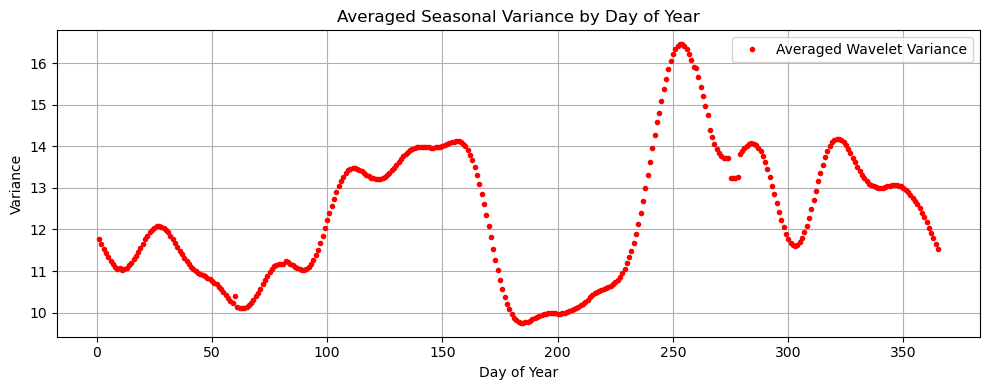

In [39]:
df['seasonal_volatility'] = volatility_seasonal[:len(df)]  # Ensure matching length

# =============================================================================
# STEP 4: Prepare Averaged Data by Day of Year for Fourier Fitting
#
# Since the paper assumes var(t+365)=var(t), we average the wavelet variance 
# over each day-of-year (1 to 365).
# =============================================================================
avg_var = df.groupby('day_of_year')['seasonal_volatility'].mean()
days = np.arange(1, 366)
avg_var_values = avg_var.reindex(days).values

plt.figure(figsize=(10, 4))
plt.plot(days, avg_var_values, 'r.', label='Averaged Wavelet Variance')
plt.title("Averaged Seasonal Variance by Day of Year")
plt.xlabel("Day of Year")
plt.ylabel("Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



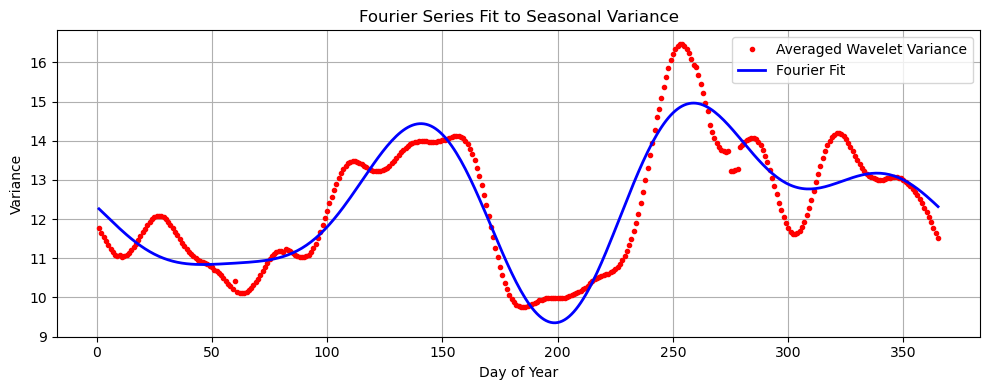

In [40]:

# =============================================================================
# STEP 5: Define the Truncated Fourier Series Model for Variance
#
# We use the following model:
#
#   var(t) = c0 + sum_{k=1}^K [ a_k*cos(2*pi*k*t/365) + b_k*sin(2*pi*k*t/365) ]
#
# For demonstration, we set K = 4 harmonics.
# =============================================================================
def fourier_variance_model(t, c0, a1, b1, a2, b2, a3, b3, a4, b4):
    return (c0 +
            a1 * np.cos(2 * np.pi * 1 * t / 365) + b1 * np.sin(2 * np.pi * 1 * t / 365) +
            a2 * np.cos(2 * np.pi * 2 * t / 365) + b2 * np.sin(2 * np.pi * 2 * t / 365) +
            a3 * np.cos(2 * np.pi * 3 * t / 365) + b3 * np.sin(2 * np.pi * 3 * t / 365) +
            a4 * np.cos(2 * np.pi * 4 * t / 365) + b4 * np.sin(2 * np.pi * 4 * t / 365))

# =============================================================================
# STEP 6: Fit the Fourier Model Using curve_fit
#
# Although this model is linear in parameters, we will use curve_fit for consistency.
# =============================================================================
# Initial guesses (adjust these as needed based on the scale of your variance)
initial_guess = [5, 1, 1, 0.5, 0.5, 0.2, 0.2, 0.1, 0.1]

popt, pcov = curve_fit(fourier_variance_model, days, avg_var_values, p0=initial_guess)

# Generate the fitted variance values from the Fourier model
fitted_var_fourier = fourier_variance_model(days, *popt)

# =============================================================================
# STEP 7: Plot the Fourier Fit vs Averaged Wavelet Variance
# =============================================================================
plt.figure(figsize=(10, 4))
plt.plot(days, avg_var_values, 'r.', label='Averaged Wavelet Variance')
plt.plot(days, fitted_var_fourier, 'b-', linewidth=2, label='Fourier Fit')
plt.title("Fourier Series Fit to Seasonal Variance")
plt.xlabel("Day of Year")
plt.ylabel("Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [41]:
print(fitted_var_fourier.shape)


(365,)


In [42]:
# Get day of year for each date in your dataframe
# If date is a column:
day_of_year = df['date'].dt.dayofyear

# If date is the index:
# day_of_year = df.index.dayofyear

# Create a mapping from day of year (1-366) to the fitted variance values
# We need a 366-day mapping to handle leap years (day 366 will just use day 365's value)
day_to_variance = {}
for i, day in enumerate(days):
    day_int = int(day)
    day_to_variance[day_int] = np.sqrt(fitted_var_fourier[i])

# If there's no day 366 in the model but we have leap years in the data
if 366 not in day_to_variance and max(days) < 366:
    day_to_variance[366] = day_to_variance[365]  # Use last day for leap years

# Map the sigma values to each day in the dataframe
df['sigma_t'] = day_of_year.map(lambda x: day_to_variance.get(x, np.nan))

# Check if all days got mapped properly
if df['sigma_t'].isna().any():
    print(f"Warning: {df['sigma_t'].isna().sum()} dates could not be mapped to the seasonal variance model")

In [43]:
# =============================================================================
# STEP 8: Print Fitted Parameters (Optional)
# =============================================================================
param_names = ['c0', 'a1', 'b1', 'a2', 'b2', 'a3', 'b3', 'a4', 'b4']
print("Fitted Fourier Model Parameters for Seasonal Variance:")
for name, value in zip(param_names, popt):
    print(f"{name} = {value:.4f}")

Fitted Fourier Model Parameters for Seasonal Variance:
c0 = 12.3430
a1 = -0.0125
b1 = -0.7440
a2 = -0.7774
b2 = -1.0568
a3 = 1.0042
b3 = 0.7934
a4 = -0.2390
b4 = -0.6903


# Residual analysis

In [44]:
epsilons = []

for t in range(1, len(df)):
    # predicted next residual by the model (without noise)
    T_tilde_model = (1.0 + df.loc[t-1, 'k_t']) * df.loc[t-1, 'residual']
    
    # actual residual at time t
    T_tilde_actual = df.loc[t, 'residual']
    
    # difference from model prediction
    diff = T_tilde_actual - T_tilde_model
    
    # realized epsilon
    e_t = diff / df.loc[t, 'sigma_t']
    
    epsilons.append(e_t)

epsilons = np.array(epsilons)

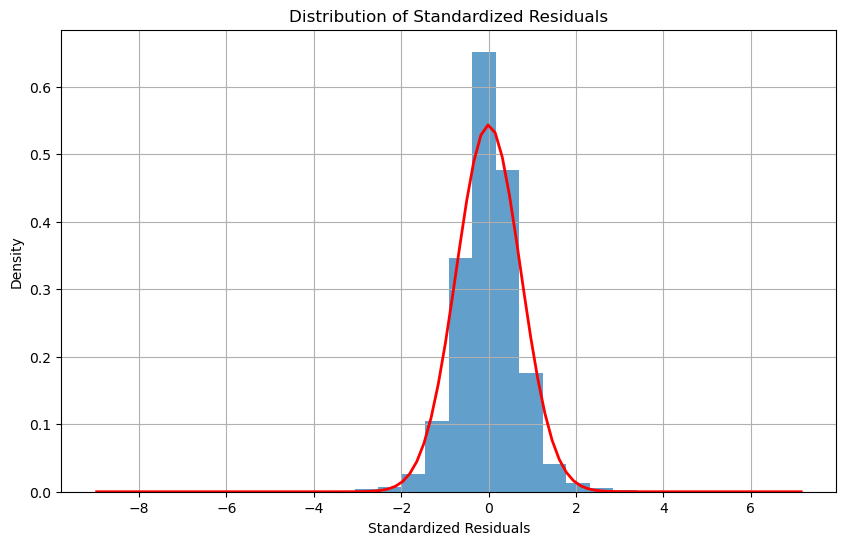

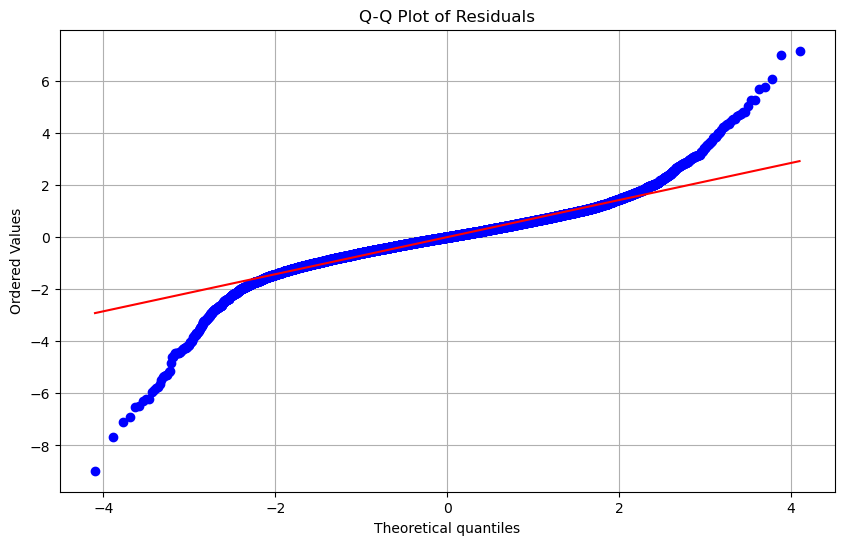

<Figure size 1000x600 with 0 Axes>

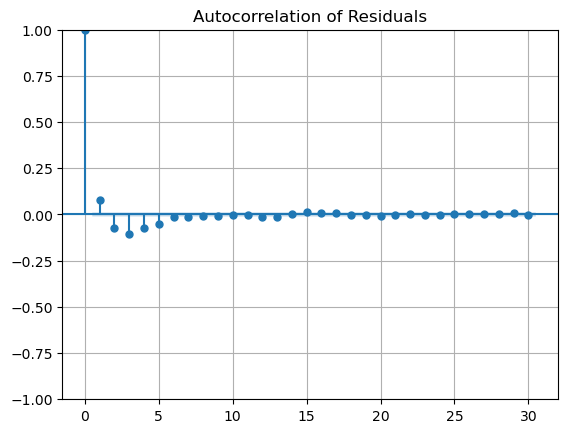


Residuals Summary Statistics:
Mean: -0.0036
Std Dev: 0.7342
Skewness: -0.2758
Kurtosis: 7.8056

Jarque-Bera test for normality:
Statistic: 84836.4871
P-value: 0.0000
Reject normality hypothesis: True

Ljung-Box test for autocorrelation (lag=10):


ValueError: Unknown format code 'f' for object of type 'str'

In [45]:
# Step 8: Check residuals for normality and independence
plt.figure(figsize=(10, 6))
plt.hist(epsilons, bins=30, alpha=0.7, density=True)
plt.title('Distribution of Standardized Residuals')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')

# Add normal distribution curve
x = np.linspace(min(epsilons), max(epsilons), 100)
plt.plot(x, stats.norm.pdf(x, np.mean(epsilons), np.std(epsilons)), 'r-', linewidth=2)
plt.grid(True)
plt.show()

# QQ plot for residuals
plt.figure(figsize=(10, 6))
stats.probplot(epsilons, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.show()

# ACF plot of residuals
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(epsilons, lags=30)
plt.title('Autocorrelation of Residuals')
plt.grid(True)
plt.show()

# Summary statistics
print("\nResiduals Summary Statistics:")
print(f"Mean: {np.mean(epsilons):.4f}")
print(f"Std Dev: {np.std(epsilons):.4f}")
print(f"Skewness: {stats.skew(epsilons):.4f}")
print(f"Kurtosis: {stats.kurtosis(epsilons):.4f}")

# Jarque-Bera test for normality
jb_stat, jb_pval = stats.jarque_bera(epsilons)
print(f"\nJarque-Bera test for normality:")
print(f"Statistic: {jb_stat:.4f}")
print(f"P-value: {jb_pval:.4f}")
print(f"Reject normality hypothesis: {jb_pval < 0.05}")

# Ljung-Box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_stat, lb_pval = acorr_ljungbox(epsilons, lags=[10], return_df=False)
print(f"\nLjung-Box test for autocorrelation (lag=10):")
print(f"Statistic: {lb_stat[0]:.4f}")
print(f"P-value: {lb_pval[0]:.4f}")
print(f"Reject independence hypothesis: {lb_pval[0] < 0.05}")